In [1]:
#Source: https://www.kaggle.com/code/charel/learn-by-example-expectation-maximization/notebook
# Objective: Let's etimate the probability distribution in a dataset that we generated 
# by using two gaussian normal probability distributions.

# Using a Gaussian mixture model with two normal distributions

# ------ libraries 
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline
#for matrix math
import numpy as np
#for normalization + probability density function computation
from scipy import stats
#for data preprocessing
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform


Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0


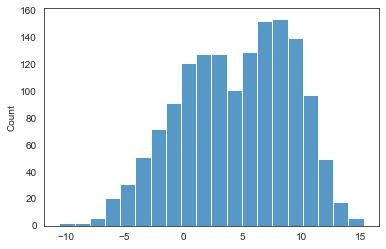

In [2]:
# generate data by giving two mean and SD to have two Normal Dist.
random_seed=36788765
np.random.seed(random_seed)

Mean1 = 2.0  # Input parameter, mean of first normal probability distribution
Standard_dev1 = 4.0 #@param {type:"number"}
Mean2 = 9.0 # Input parameter, mean of second normal  probability distribution
Standard_dev2 = 2.0 #@param {type:"number"}

# generate data
y1 = np.random.normal(Mean1, Standard_dev1, 1000)
y2 = np.random.normal(Mean2, Standard_dev2, 500)
data=np.append(y1,y2)

# For data visiualisation calculate left and right of the graph
Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000) # to plot the data

print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
sns.histplot(data, bins=20, kde=False);

In [4]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)
print("Gaussian class defined")

Gaussian class defined


In [5]:
class GaussianMixture_self:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=1, sigma_max=1, mix=.5):
        self.data = data
        #todo the Algorithm would be numerical enhanced by normalizing the data first, next do all the EM steps and do the de-normalising at the end
        
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, assign each point to gaussian 1 or 2 with a probability"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:  
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den   
            wp2 /= den     # wp1+wp2= 1, it either belongs to gaussian 1 or gaussion 2
            # add into loglike
            self.loglike += log(den) #freshening up self.loglike in the process
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights) 
        one_den = sum(left)
        two_den = sum(rigt)

        # compute new means
        self.one.mu = sum(w * d  for (w, d) in zip(left, data)) / one_den
        self.two.mu = sum(w * d  for (w, d) in zip(rigt, data)) / two_den
        
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / two_den)
        # compute new mix
        self.mix = one_den / len(data)

        
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)
print("done")


done


In [9]:
# See the algorithm in action
n_iterations = 20
best_mix = None
best_loglike = float('-inf')
mix = GaussianMixture_self(data)
for _ in range(n_iterations):
    try:
        #train!
        mix.iterate(verbose=True)
        if mix.loglike > best_loglike:
            best_loglike = mix.loglike
            best_mix = mix
        
    except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
        print("one less")
        pass

 1 Mixture: Gaussian(-1.03094, 2.38804), Gaussian(7.20556, 2.89), mix=0.335)
 1 Mixture: Gaussian(-0.778422, 2.65484), Gaussian(7.13032, 3.05409), mix=0.339)
 1 Mixture: Gaussian(-0.633979, 2.77717), Gaussian(7.12136, 3.10768), mix=0.344)
 1 Mixture: Gaussian(-0.536737, 2.84691), Gaussian(7.13592, 3.12269), mix=0.35)
 1 Mixture: Gaussian(-0.463029, 2.89144), Gaussian(7.16153, 3.12032), mix=0.356)
 1 Mixture: Gaussian(-0.402198, 2.92249), Gaussian(7.19287, 3.10909), mix=0.361)
 1 Mixture: Gaussian(-0.348845, 2.94589), Gaussian(7.22729, 3.09303), mix=0.367)
 1 Mixture: Gaussian(-0.300031, 2.96486), Gaussian(7.26336, 3.07428), mix=0.372)
 1 Mixture: Gaussian(-0.254085, 2.98119), Gaussian(7.30021, 3.05404), mix=0.377)
 1 Mixture: Gaussian(-0.21003, 2.99598), Gaussian(7.33736, 3.03301), mix=0.383)
 1 Mixture: Gaussian(-0.167287, 3.00985), Gaussian(7.37449, 3.01162), mix=0.388)
 1 Mixture: Gaussian(-0.125508, 3.0232), Gaussian(7.41141, 2.99013), mix=0.393)
 1 Mixture: Gaussian(-0.0844873, 3.

Computing best model with random restarts...

Input Gaussian 1: μ = 2.0, σ = 4.0
Input Gaussian 2: μ = 9.0, σ = 2.0
Gaussian 1: μ = 1.6, σ = 3.7, weight = 0.6
Gaussian 2: μ = 8.7, σ = 2.3, weight = 0.4


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


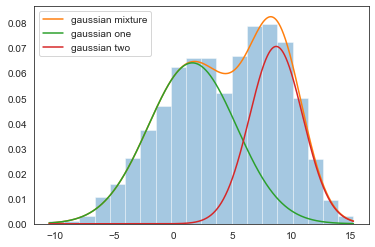

In [15]:
# Find best Mixture Gaussian model
n_iterations = 50
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture_self(data)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
#print('Best Gaussian Mixture : μ = {:.2}, σ = {:.2} with μ = {:.2}, σ = {:.2}'.format(best_mix.one.mu, best_mix.one.sigma, best_mix.two.mu, best_mix.two.sigma))

print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("1", Mean1, Standard_dev1))
print('Input Gaussian {:}: μ = {:.2}, σ = {:.2}'.format("2", Mean2, Standard_dev2))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("1", best_mix.one.mu, best_mix.one.sigma, best_mix.mix))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("2", best_mix.two.mu, best_mix.two.sigma, (1-best_mix.mix)))
#Show mixture
sns.distplot(data, bins=20, kde=False, norm_hist=True);
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
g_left = [best_mix.one.pdf(e) * best_mix.mix for e in x]
plt.plot(x, g_left, label='gaussian one');
g_right = [best_mix.two.pdf(e) * (1-best_mix.mix) for e in x]
plt.plot(x, g_right, label='gaussian two');
plt.legend();
